In [1]:
import plotly.graph_objects as go
# import kaleido
from plotly.subplots import make_subplots
import plotly.io as pio
import pandas as pd
import numpy as np
import json

from statsmodels.tsa.seasonal import seasonal_decompose

# local modules 
import sys
sys.path.insert(0, "../scripts")
import helpers as h
import seaborn as sns

In [2]:
a00, a01 = h.import_desired_data("A", "15T")
# TODO edit in function 
a00.set_index(a00["DateTime"].values, inplace=True)
a01.set_index(a01["DateTime"].values, inplace=True)
print(a00["Window Open"].unique(), a01["Window Open"].unique(), a00.columns)

[1.] [0. 1.] Index(['DateTime', 'Temp C', 'RH %', 'Room', 'Ambient Temp', 'Ambient RH',
       'Window Open'],
      dtype='object')


## room 0 difference

### STL

96


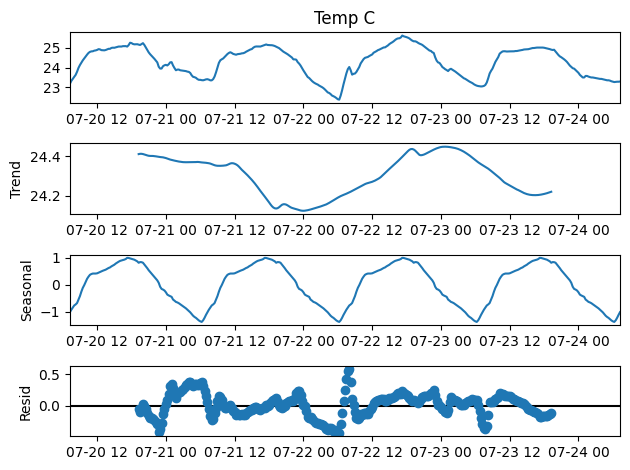

In [3]:
# period => # samples per unit in length of time over which seasonality occurs (here, 4 samples/1 hour) * length of time over which seasonality occurs (here, 24 hours)
n_samples = 4
seasonality_period = 24
period = n_samples*seasonality_period
print(period)


stl = seasonal_decompose(a00["Temp C"],model='additive', period=period)

stl.plot();

### differencing 

In [4]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x=a01["DateTime"],
                    y=h.normalize(a01["Window Open"]), 
                    mode='lines',
                    name="Window Sched",
                    line=dict(width=1),
                ))

fig.add_trace(go.Scatter(
                    x=a01["DateTime"],
                    y=h.normalize(a01["Temp C"]), 
                    mode='lines',
                    name="Variable Open, Normalized Observation"
                ))

fig.add_trace(go.Scatter(
                    x=stl.seasonal.index,
                    y=h.normalize(stl.seasonal), 
                    mode='lines',
                    name="STL Seasonal,Temp ConstantOpen Rm"
                ))

# # calculate the difference 
dif = h.normalize(h.normalize(stl.seasonal) - h.normalize(a01["Temp C"]))
fig.add_trace(go.Scatter(
                    x=dif.index,
                    y=dif, 
                    mode='lines',
                    name="Difference"
                ))

# calculate "derivative"
deriv = h.normalize(pd.Series(np.gradient(dif.values), dif.index, name='deriv'))
fig.add_trace(go.Scatter(
                    x=deriv.index,
                    y=deriv, 
                    mode='lines',
                    name="1st Deriv"
                ))

## room 1 difference

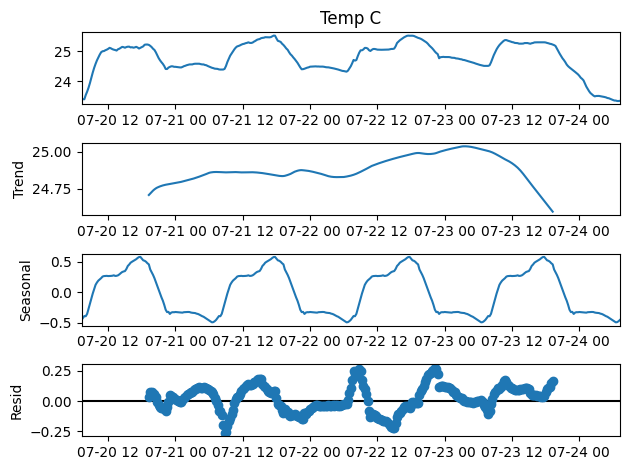

In [5]:
stl_var = seasonal_decompose(a01["Temp C"],model='additive', period=period)

stl_var.plot();

In [6]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x=a01["DateTime"].index,
                    y=h.normalize(a01["Window Open"]), 
                    mode='lines',
                    name="Window Sched",
                    line=dict(width=1),
                ))

fig.add_trace(go.Scatter(
                    x=a01["DateTime"].index,
                    y=h.normalize(a01["Temp C"]), 
                    mode='lines',
                    name="Variable Open, Normalized Observation"
                ))

fig.add_trace(go.Scatter(
                    x=stl_var.seasonal.index,
                    y=h.normalize(stl_var.seasonal), 
                    mode='lines',
                    name="STL Seasonal,Temp Variable Rm"
                ))

dif = h.normalize(h.normalize(stl_var.seasonal) - h.normalize(a01["Temp C"]))

fig.add_trace(go.Scatter(
                    x=stl_var.seasonal.index,
                    y=dif, 
                    mode='lines',
                    name="Difference"
                ))


# calculate "derivative"
deriv = h.normalize(pd.Series(np.gradient(dif.values), dif.index, name='deriv'))
fig.add_trace(go.Scatter(
                    x=deriv.index,
                    y=deriv, 
                    mode='lines',
                    name="1st Deriv"
                ))



## observation only approach

In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x=a01["DateTime"].index,
                    y=h.normalize(a01["Window Open"]), 
                    mode='lines',
                    name="Window Sched",
                    line=dict(width=1),
                ))

fig.add_trace(go.Scatter(
                    x=a01["DateTime"].index,
                    y=h.normalize(a01["Temp C"]), 
                    mode='lines',
                    name="Variable Open Obs"
                ))



# calculate derivative of observation only 
obs_deriv = h.normalize(pd.Series(np.gradient(a01["Temp C"]), a01.index, name='obs_deriv'))
fig.add_trace(go.Scatter(
                    x=obs_deriv.index,
                    y=obs_deriv, 
                    mode='lines',
                    name="Obs 1st Deriv "
                ))

fig.update_xaxes(
    dtick=4*60*60*1000, #1 hr in miliseconds,
    tickformat='%a-%H')

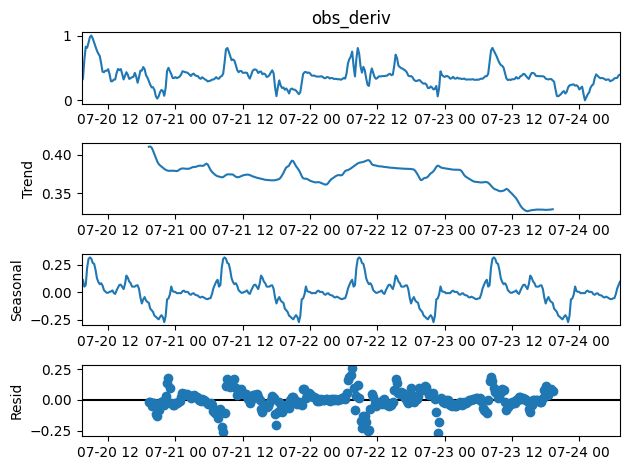

In [8]:
stl_deriv = seasonal_decompose(obs_deriv,model='additive', period=period)

stl_deriv.plot();

In [9]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x=a01["DateTime"].index,
                    y=h.normalize(a01["Window Open"]), 
                    mode='lines',
                    name="Window Sched",
                    line=dict(width=1),
                ))

fig.add_trace(go.Scatter(
                    x=a01["DateTime"].index,
                    y=h.normalize(a01["Temp C"]), 
                    mode='lines',
                    name="Variable Open Obs"
                ))



# calculate derivative of observation only 
obs_deriv = h.normalize(pd.Series(np.gradient(a01["Temp C"]), a01.index, name='obs_deriv'))
fig.add_trace(go.Scatter(
                    x=obs_deriv.index,
                    y=obs_deriv, 
                    mode='lines',
                    name="Obs 1st Deriv "
                ))

# difference between this stl decomp 
stl_deriv_dif = h.normalize(h.normalize(stl_deriv.seasonal) - h.normalize(a01["Window Open"]))
fig.add_trace(go.Scatter(
                    x=stl_deriv_dif.index,
                    y=stl_deriv_dif, 
                    mode='lines',
                    name="Obs STL Dif  Deriv "
                ))

stl_deriv_dif_deriv = h.normalize(pd.Series(np.gradient(stl_deriv_dif), dif.index, name='deriv'))
fig.add_trace(go.Scatter(
                    x=stl_deriv_dif_deriv.index,
                    y=stl_deriv_dif_deriv, 
                    mode='lines',
                    name="Deriv of Obs STL Dif  Deriv "
                ))


# second deriv doesnt look very helpful 
# stl_deriv_dif_deriv2 = h.normalize(pd.Series(np.gradient(stl_deriv_dif_deriv), dif.index, name='deriv'))
# fig.add_trace(go.Scatter(
#                     x=stl_deriv_dif_deriv2.index,
#                     y=stl_deriv_dif_deriv2, 
#                     mode='lines',
#                     name="2 Deriv of Obs STL Dif  Deriv "
#                 ))


fig.update_xaxes(
    dtick=4*60*60*1000, #1 hr in miliseconds,
    tickformat='%a-%H')

#### anomaly detection 

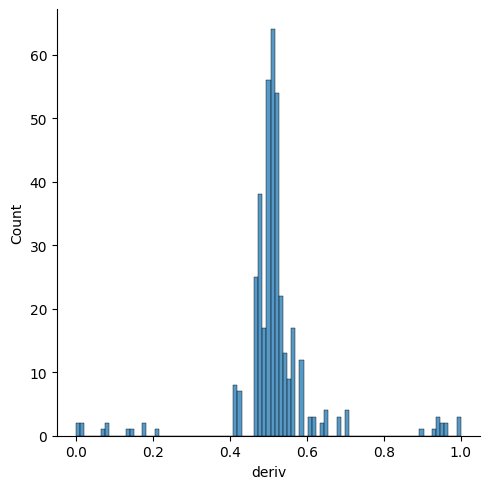

In [10]:
# look at prbability distributions...
s3d = stl_deriv_dif_deriv
sns.displot(s3d)

In [11]:
def calc_zscore(arr):
    z_score = np.apply_along_axis(lambda x, mean, std: (x - mean)/std, 0, arr, arr.mean(), arr.std())
    return z_score

In [12]:
z_s3d = calc_zscore(s3d)
type(z_s3d)

numpy.ndarray

In [13]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x=a01["DateTime"].index,
                    y=h.normalize(a01["Window Open"]), 
                    mode='lines',
                    name="Window Sched",
                    line=dict(width=1),
                ))




fig.add_trace(go.Scatter(
                    x=a01["DateTime"].index,
                    y=z_s3d , 
                    mode='lines',
                    name="z score",
                    # line=dict(width=1),
                ))




# Archives

### ambient temp seasonal decomposition 

96


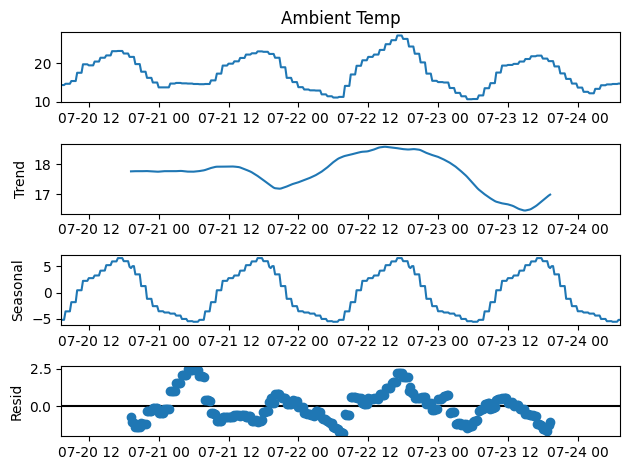

In [14]:
# period => # samples per unit in length of time over which seasonality occurs (here, 4 samples/1 hour) * length of time over which seasonality occurs (here, 24 hours)
n_samples = 4
seasonality_period = 24
period = n_samples*seasonality_period
print(period)

results_amb = seasonal_decompose(a00["Ambient Temp"],model='additive', period=period)

results_amb.plot();